In [1]:
# OUTLINE

# many columns with small number of Y/N, rest missing: for categorical, make category for missing
# - possible thoughts: outcome by "assigned by" (aka who called it in); outcome by race, gang affiliation, etc

# add in: statistical likelihood that "worst 20" officers are due to random chance
# add in: time series analysis

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 200)

In [3]:
df_clean = pd.read_csv('ISR_data_clean.csv',low_memory=False)
df_clean.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,HOTSPOT_NO,EVENT_NO,MISSION_NO,CPD_UNIT_NO,CREATED_BY,CREATED_DATE,MODIFIED_BY,MODIFIED_DATE,AGE,AGE_TO,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,STREET_NO,STREET_DIRECTION_CD,STREET_NME,CITY,STATE_CD,ZIP_CD,DISTRICT,SECTOR,BEAT,AREA,RES_DISTRICT,RES_SECTOR,RES_BEAT,RES_AREA,BUS_DISTRICT,BUS_SECTOR,BUS_BEAT,BUS_AREA,SUBMITTING_UNIT,CONTACT_TYPE_DESCR,V_YEAR,MAKE_CD,MAKE_DESCR,STYLE_CD,STYLE_DESCR,MODEL_DESCR,COLOR_TOP,COLOR_BOTTOM,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,GANG,KNOWN_HANGOUT,FACTION_NAME,CONTACT_CARD_STATUS_CD,LOCATION_CD,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,FIREARM_I,COCAINE_I,COCAINE_AMOUNT,HEROIN_I,HEROIN_AMOUNT,OTHER_WEAPON_I,OTHER_WEAPON_DESCR,CANNABIS_I,CANNABIS_AMOUNT,OTHER_CON_SUB_I,OTHER_CON_SUB,OTHER_CON_SUB_AMT,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CONTRABAND_FOUND_I,SEARCH_FIREARM_I,SEARCH_COCAINE_I,SEARCH_COCAINE_AMOUNT,SEARCH_HEROIN_I,SEARCH_HEROIN_AMOUNT,SEARCH_OTHER_WEAPON_I,SEARCH_OTHER_WEAPON_DESCR,SEARCH_CANNABIS_I,SEARCH_CANNABIS_AMOUNT,SEARCH_OTHER_CON_SUB_I,SEARCH_OTHER_CON_SUB_DESCR,SEARCH_OTHER_CON_SUB_AMT,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ENFORCEMENT_ID_NO,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME
0,20410357,INVSTG,ISR000410357,01-JAN-2018 00:08,0,2523,N,"BROWN JACKET, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:46,185285.0,01-JAN-2018 01:47,30.0,NaN,M,WWH,506,165,MED,BRO,BLK,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,16.0,163.0,1634.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN
1,20410350,INVSTG,ISR000410350,01-JAN-2018 00:08,0,2523,N,BLUE JEANS AND A BLACK SWEATER,NaN,JB100012,NaN,121,NaN,25,675642,01-JAN-2018 01:35,675642.0,01-JAN-2018 01:38,20.0,NaN,M,WWH,510,175,MED,BRO,BLK,MED,LBR,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,252.0,2523.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675642,845723.0,184324.0,NaN,NaN,NaN,APP,289,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20410351,INVSTG,ISR000410351,01-JAN-2018 00:08,0,2523,N,"GRAY HOODED SWEATER, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:35,185285.0,01-JAN-2018 01:36,23.0,NaN,M,WWH,508,170,MED,BRO,BAL,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,253.0,2535.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,N

In [4]:
# first, check for duplicates

# "Unique ID for the ISR version record - If there have been any revisions of the ISR, there can be multiple CONTACT_CARD_ID values per CARD_NO"

display(df_clean['CARD_NO'].nunique())
display(df_clean['CONTACT_CARD_ID'].nunique())

290145

290145

In [5]:
# exploring further from our EDA

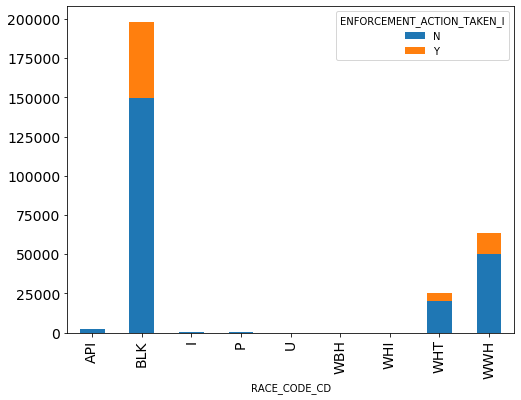

In [6]:
df_clean.groupby(["RACE_CODE_CD","ENFORCEMENT_ACTION_TAKEN_I"]).size().unstack().plot(kind='bar', stacked=True, figsize=(8,6),fontsize=14) 

# add percentages to this
# compare numbers below (and percenages overall) to demographics of Chicago

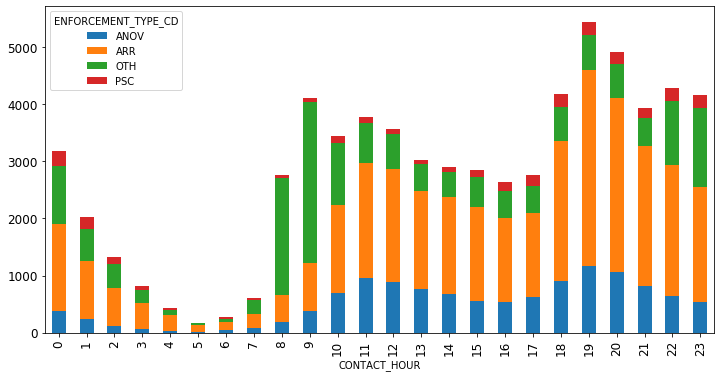

In [7]:
df_clean.groupby(["CONTACT_HOUR","ENFORCEMENT_TYPE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

In [8]:
# next, limit this to arrests only

arrests_only = df_clean.loc[df_clean["ENFORCEMENT_TYPE_CD"] == "ARR"]
arrests_only.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,HOTSPOT_NO,EVENT_NO,MISSION_NO,CPD_UNIT_NO,CREATED_BY,CREATED_DATE,MODIFIED_BY,MODIFIED_DATE,AGE,AGE_TO,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,STREET_NO,STREET_DIRECTION_CD,STREET_NME,CITY,STATE_CD,ZIP_CD,DISTRICT,SECTOR,BEAT,AREA,RES_DISTRICT,RES_SECTOR,RES_BEAT,RES_AREA,BUS_DISTRICT,BUS_SECTOR,BUS_BEAT,BUS_AREA,SUBMITTING_UNIT,CONTACT_TYPE_DESCR,V_YEAR,MAKE_CD,MAKE_DESCR,STYLE_CD,STYLE_DESCR,MODEL_DESCR,COLOR_TOP,COLOR_BOTTOM,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,GANG,KNOWN_HANGOUT,FACTION_NAME,CONTACT_CARD_STATUS_CD,LOCATION_CD,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,FIREARM_I,COCAINE_I,COCAINE_AMOUNT,HEROIN_I,HEROIN_AMOUNT,OTHER_WEAPON_I,OTHER_WEAPON_DESCR,CANNABIS_I,CANNABIS_AMOUNT,OTHER_CON_SUB_I,OTHER_CON_SUB,OTHER_CON_SUB_AMT,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CONTRABAND_FOUND_I,SEARCH_FIREARM_I,SEARCH_COCAINE_I,SEARCH_COCAINE_AMOUNT,SEARCH_HEROIN_I,SEARCH_HEROIN_AMOUNT,SEARCH_OTHER_WEAPON_I,SEARCH_OTHER_WEAPON_DESCR,SEARCH_CANNABIS_I,SEARCH_CANNABIS_AMOUNT,SEARCH_OTHER_CON_SUB_I,SEARCH_OTHER_CON_SUB_DESCR,SEARCH_OTHER_CON_SUB_AMT,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ENFORCEMENT_ID_NO,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME
8,20410600,INVSTG,ISR000410600,01-JAN-2018 00:35,0,1461,N,GRAY SWEATER,NaN,JA100059,NaN,668,NaN,14,555358,01-JAN-2018 12:45,555358.0,01-JAN-2018 12:55,25.0,NaN,M,BLK,510,150,MED,BRO,BLK,CRS,MBR,29XX,W,MEDILL AVE,CHICAGO,IL,60647,14,141,1414,3,5.0,51.0,511.0,2,NaN,NaN,NaN,0,14,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,555358,614048.0,621961.0,NaN,NaN,NaN,APP,291,N,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,Y,Y,Y,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,ARR,19582916,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,20410598,INVSTG,ISR000410598,01-JAN-2018 00:35,0,1461,N,WHITE SHIRT,NaN,JB100059,NaN,668,NaN,14,555358,01-JAN-2018 12:35,555358.0,01-JAN-2018 12:55,19.0,NaN,M,BLK,509,120,SLN,BRO,BLK,SHORT,MBR,29XX,W,MEDILL AVE,CHICAGO,IL,60647,14,141,1414,3,7.0,73.0,734.0,2,NaN,NaN,NaN,0,14,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,555358,614048.0,621961.0,NaN,NaN,NaN,APP,291,N,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,Y,Y,Y,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,ARR,19582915,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,20410597,INVSTG,ISR000410597,01-JAN-2018 00:38,0,1461,N,BLACK AND GRAY HOODED SWEATER,NaN,JB100059,NaN,668,NaN,14,555358,01-JAN-2018 12:35,555358.0,01-JAN-2018 12:57,35.0,NaN,M,BLK,508,170,MED,BRO,BLK,MEDIUM,DRK,29XX,W,BELDEN AVE,CHICAGO,IL,60647,14,141,1414,3,31.0,310.0,3100.0,0,NaN,NaN,NaN,0,14,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,555358,614048.0,621961.0,NaN,NaN,NaN,APP,291,N,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,Y,Y,Y,NaN,Y,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,ARR,19582910,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,20410354,INVS

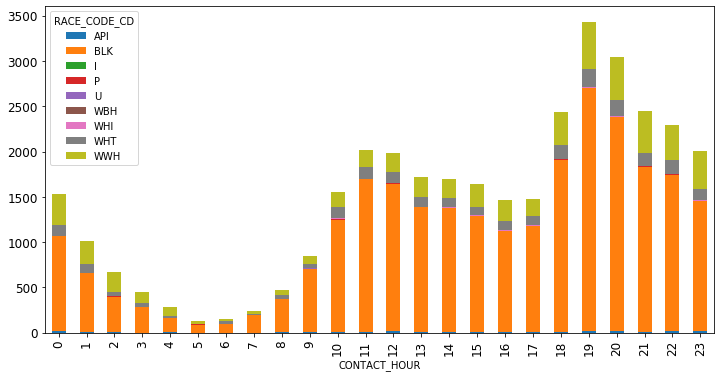

In [9]:
arrests_only.groupby(["CONTACT_HOUR","RACE_CODE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)
# this is a combo of the previous charts
# arrests only (so action taken is also Y), looking at race and hour

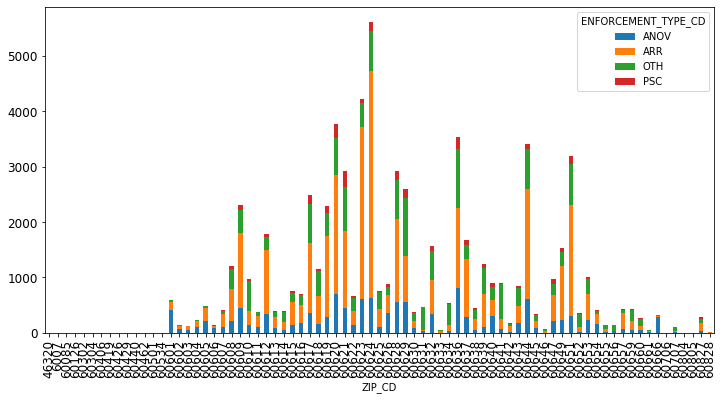

In [10]:
df_clean.groupby(["ZIP_CD","ENFORCEMENT_TYPE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

In [11]:
# create basic model using these three columns
# how accurate can we get (arrest or not) using only race, zipcode and contact hour?

In [12]:
first_model = df_clean[["ZIP_CD","ENFORCEMENT_TYPE_CD","CONTACT_HOUR", "RACE_CODE_CD"]]
first_model.head()

,ZIP_CD,ENFORCEMENT_TYPE_CD,CONTACT_HOUR,RACE_CODE_CD
0,60641,NaN,0,WWH
1,60641,NaN,0,WWH
2,60641,NaN,0,WWH
3,60634,NaN,0,WWH
4,60621,NaN,0,BLK


In [13]:
# remove rows with missing zipcode
# change enforcement_type_cd to binary
# anything but arr = 0, arr = 1

In [14]:
first_model.dropna(subset = ["ZIP_CD"], axis=0, inplace=True)
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289734 entries, 0 to 290144
Data columns (total 4 columns):
ZIP_CD                 289734 non-null object
ENFORCEMENT_TYPE_CD    67459 non-null object
CONTACT_HOUR           289734 non-null int64
RACE_CODE_CD           289734 non-null object
dtypes: int64(1), object(3)
memory usage: 11.1+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
# we have 67k lines with enforcement type - plenty to go off of!

first_model.dropna(subset = ["ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)
first_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67459 entries, 8 to 290144
Data columns (total 4 columns):
ZIP_CD                 67459 non-null object
ENFORCEMENT_TYPE_CD    67459 non-null object
CONTACT_HOUR           67459 non-null int64
RACE_CODE_CD           67459 non-null object
dtypes: int64(1), object(3)
memory usage: 2.6+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# re-setting our axis

first_model.reset_index(drop=True, inplace=True)
first_model.head()

,ZIP_CD,ENFORCEMENT_TYPE_CD,CONTACT_HOUR,RACE_CODE_CD
0,60647,ARR,0,BLK
1,60647,ARR,0,BLK
2,60647,ARR,0,BLK
3,60610,OTH,0,WWH
4,60610,OTH,0,BLK


In [17]:
# now, create a target column

first_model['TARGET'] = np.where(first_model['ENFORCEMENT_TYPE_CD'] == 'ARR', 1, 0)
first_model.head()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ZIP_CD,ENFORCEMENT_TYPE_CD,CONTACT_HOUR,RACE_CODE_CD,TARGET
0,60647,ARR,0,BLK,1
1,60647,ARR,0,BLK,1
2,60647,ARR,0,BLK,1
3,60610,OTH,0,WWH,0
4,60610,OTH,0,BLK,0


In [18]:
# we're going to drop the enforcement type column now
# since this informed our target, we'll need to remove that from our model or risk leakage

first_model.drop(columns = ["ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)
first_model.head()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD,TARGET
0,60647,0,BLK,1
1,60647,0,BLK,1
2,60647,0,BLK,1
3,60610,0,WWH,0
4,60610,0,BLK,0


In [19]:
y = first_model['TARGET']

In [20]:
first_model_data = first_model.drop(["TARGET"], axis = 1)
first_model_data.head()

,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD
0,60647,0,BLK
1,60647,0,BLK
2,60647,0,BLK
3,60610,0,WWH
4,60610,0,BLK


In [21]:
# move on to the model

In [22]:
# last check for missing values

first_model.isna().sum()

ZIP_CD          0
CONTACT_HOUR    0
RACE_CODE_CD    0
TARGET          0
dtype: int64

In [23]:
# zip code, race code need to be one-hot encoded
# (zip code is technically a number, but should be treated categorically)

label_encoder_zip = LabelEncoder()
label_encoder_zip = label_encoder_zip.fit(y)
label_encoded_y = label_encoder_zip.transform(y)

In [24]:
label_encoder_race = LabelEncoder()
label_encoder_race = label_encoder_race.fit(y)
label_encoded_y = label_encoder_race.transform(y)

In [25]:
first_model_data['RACE_CODE_CD'] = label_encoder_race.fit_transform(first_model_data['RACE_CODE_CD'])
first_model_data.head()

,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD
0,60647,0,1
1,60647,0,1
2,60647,0,1
3,60610,0,8
4,60610,0,1


In [26]:
first_model_data = pd.get_dummies(first_model_data, columns=['RACE_CODE_CD'])
first_model_data.head()

,ZIP_CD,CONTACT_HOUR,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8
0,60647,0,0,1,0,0,0,0,0,0,0
1,60647,0,0,1,0,0,0,0,0,0,0
2,60647,0,0,1,0,0,0,0,0,0,0
3,60610,0,0,0,0,0,0,0,0,0,1
4,60610,0,0,1,0,0,0,0,0,0,0


In [27]:
# and we'll repeat that with zipcode now

first_model_data['ZIP_CD'] = label_encoder_zip.fit_transform(first_model_data['ZIP_CD'])
first_model_data = pd.get_dummies(first_model_data, columns=['ZIP_CD'])
first_model_data.head()

,CONTACT_HOUR,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8,ZIP_CD_0,ZIP_CD_1,ZIP_CD_2,ZIP_CD_3,ZIP_CD_4,ZIP_CD_5,ZIP_CD_6,ZIP_CD_7,ZIP_CD_8,ZIP_CD_9,ZIP_CD_10,ZIP_CD_11,ZIP_CD_12,ZIP_CD_13,ZIP_CD_14,ZIP_CD_15,ZIP_CD_16,ZIP_CD_17,ZIP_CD_18,ZIP_CD_19,ZIP_CD_20,ZIP_CD_21,ZIP_CD_22,ZIP_CD_23,ZIP_CD_24,ZIP_CD_25,ZIP_CD_26,ZIP_CD_27,ZIP_CD_28,ZIP_CD_29,ZIP_CD_30,ZIP_CD_31,ZIP_CD_32,ZIP_CD_33,ZIP_CD_34,ZIP_CD_35,ZIP_CD_36,ZIP_CD_37,ZIP_CD_38,ZIP_CD_39,ZIP_CD_40,ZIP_CD_41,ZIP_CD_42,ZIP_CD_43,ZIP_CD_44,ZIP_CD_45,ZIP_CD_46,ZIP_CD_47,ZIP_CD_48,ZIP_CD_49,ZIP_CD_50,ZIP_CD_51,ZIP_CD_52,ZIP_CD_53,ZIP_CD_54,ZIP_CD_55,ZIP_CD_56,ZIP_CD_57,ZIP_CD_58,ZIP_CD_59,ZIP_CD_60,ZIP_CD_61,ZIP_CD_62,ZIP_CD_63,ZIP_CD_64,ZIP_CD_65,ZIP_CD_66,ZIP_CD_67,ZIP_CD_68,ZIP_CD_69,ZIP_CD_70,ZIP_CD_71,ZIP_CD_72,ZIP_CD_73,ZIP_CD_74,ZIP_CD_75,ZIP_CD_76
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(first_model_data, y, test_size = 0.25, random_state = 0,stratify=y)

In [29]:
X = first_model_data.as_matrix().astype(np.float)
X

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [23.,  0.,  1., ...,  0.,  0.,  0.],
       [23.,  0.,  1., ...,  0.,  0.,  0.],
       [23.,  0.,  1., ...,  0.,  0.,  0.]])

In [30]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[-2.1616682 , -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [-2.1616682 , -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [-2.1616682 , -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       ...,
       [ 1.35659306, -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [ 1.35659306, -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251],
       [ 1.35659306, -0.0877955 ,  0.63450032, ..., -0.0038502 ,
        -0.06479094, -0.01540251]])

In [31]:
clf = LogisticRegression(C=1.0, max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Logistic Regression Testing Accuracy: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Logistic Regression Testing Accuracy: 0.6349836940409131
AUC: 0.6327471766197548
Precision: 0.6345310215166075
Recall: 0.695716903344022
F1 Score: 0.6637168141592922


In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    """This function takes in a confusion matrix (cm) and normalizes the values if normalize is set to True. 
    If so, normalize the raw confusion matrix before visualizing.
    If false, raw confusion matrix is visualized."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    #plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

In [33]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4634 3499]
 [2657 6075]]


Normalized confusion matrix
[[0.56977745 0.43022255]
 [0.3042831  0.6957169 ]]


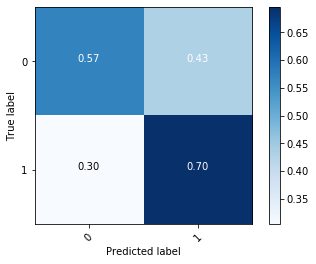

In [34]:
# Plot a normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [35]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)

print(f'Gradient Boosting: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Gradient Boosting: 0.6451823302697896
AUC: 0.640436761684003
Precision: 0.6275766016713092
Recall: 0.7740494732020156
F1 Score: 0.6931596759306738


In [36]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4122 4011]
 [1973 6759]]


Normalized confusion matrix
[[0.50682405 0.49317595]
 [0.22595053 0.77404947]]


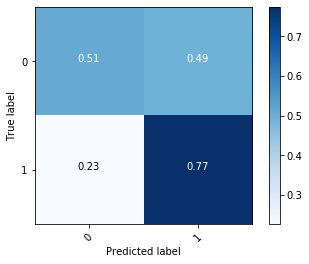

In [37]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [38]:
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(f'XGB Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

%time

XGB Classifier: 0.6633857100504003
AUC: 0.659462308058892
Precision: 0.6470022134539505
Recall: 0.7699267063673844
F1 Score: 0.7031323537101919
CPU times: user 5 µs, sys: 11 µs, total: 16 µs
Wall time: 6.91 µs


In [39]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4465 3668]
 [2009 6723]]


Normalized confusion matrix
[[0.54899791 0.45100209]
 [0.23007329 0.76992671]]


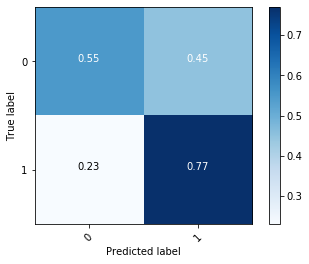

In [40]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [41]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
preds = dt.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree: 0.6557960272754225
AUC: 0.6528540994964668
Precision: 0.6475153714343312
Recall: 0.7356848373797527
F1 Score: 0.6887900069693884


In [42]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4636 3497]
 [2308 6424]]


Normalized confusion matrix
[[0.57002336 0.42997664]
 [0.26431516 0.73568484]]


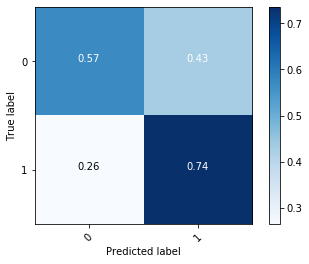

In [43]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [44]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
preds = ab.predict(X_test)


print(f'Decision Tree 2: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree 2: 0.6420990216424548
AUC: 0.6394118080092984
Precision: 0.6376633986928104
Recall: 0.7150710032065964
F1 Score: 0.674152450874541


In [45]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4585 3548]
 [2488 6244]]


Normalized confusion matrix
[[0.56375261 0.43624739]
 [0.284929   0.715071  ]]


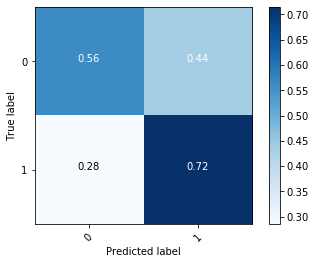

In [46]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [47]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
preds = svc.predict(X_test)


print(f'Support Vector Classification: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Support Vector Classification: 0.6336792173139638
AUC: 0.6316392643510975
Precision: 0.634704641350211
Recall: 0.6890746678882272
F1 Score: 0.6607731166264003


In [48]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[4670 3463]
 [2715 6017]]


Normalized confusion matrix
[[0.57420386 0.42579614]
 [0.31092533 0.68907467]]


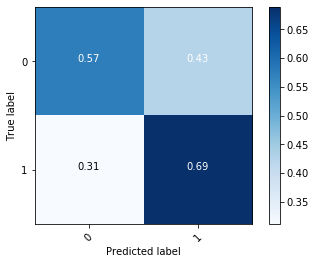

In [49]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [50]:
# FEATURE IMPORTANCE
print (xgb.feature_importances_)

[0.00781241 0.00235717 0.0082031  0.00375032 0.0018037  0.
 0.00391149 0.01250393 0.00263683 0.00490163 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03942924 0.00749536 0.00378498 0.00636595 0.00889711 0.01166571
 0.0065333  0.00598235 0.01693166 0.05300302 0.00543391 0.02406298
 0.00596509 0.00611061 0.0069169  0.00518953 0.0119246  0.01921945
 0.02298206 0.01224466 0.01491479 0.0115821  0.08849835 0.09448668
 0.00813726 0.01574265 0.00775445 0.0524409  0.01146029 0.02776271
 0.00624188 0.0030621  0.01347197 0.02772246 0.01268279 0.0050245
 0.0073184  0.0206777  0.01883158 0.0070806  0.01352299 0.01575575
 0.00909374 0.00423528 0.00609742 0.01967362 0.03718853 0.00610919
 0.00574123 0.01131625 0.00634206 0.01098412 0.01098009 0.00453524
 0.00753659 0.00323164 0.03368236 0.         0.00485548 0.
 0.         0.00437825 0.00182699]


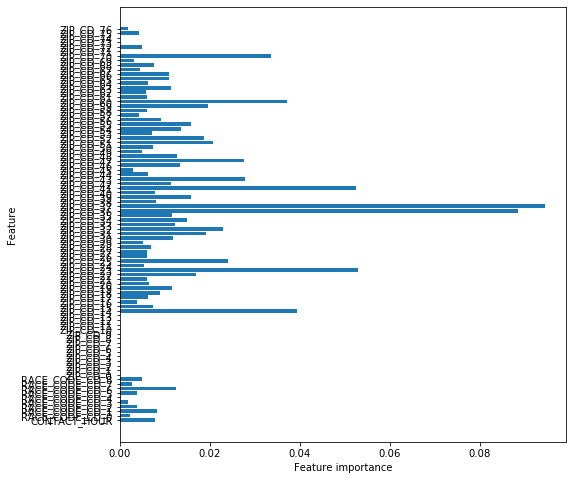

In [51]:
def plot_feature_importances(model):
    """Plots the importance of features from the model specified. Results are sorted by index."""
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(xgb)

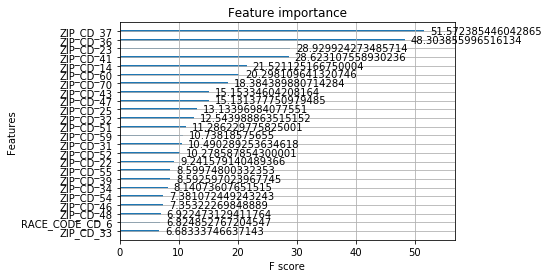

In [52]:
plot_importance(xgb,importance_type='gain', max_num_features=24)
pyplot.show()

In [53]:
display(label_encoder_zip.inverse_transform([37]))
display(label_encoder_zip.inverse_transform([36]))

array(['60624'], dtype=object)

array(['60623'], dtype=object)

In [54]:
# 60624 detail - demographics

# The largest 60624 racial/ethnic groups are Black (90.4%) followed by Hispanic (5.3%) and White (2.7%)
# In 2018, the median household income of 60624 residents was $22,992. 
# 44.2% of 60624 residents live below the poverty line. 

In [55]:
# 60623 detail - demographics

# The largest 60623 racial/ethnic groups are Hispanic (66.1%) followed by Black (30.4%) and White (2.9%).
# In 2018, the median household income of 60623 residents was $31,634. 
# 33.4% of 60623 residents live below the poverty line.

In [56]:
# These two zip codes are communities of color with widespread poverty; it's easy to see why they would 
# have higher arrest rates than the rest of the city. 

In [57]:
# add new column to represent those two zip codes

highest_two_zips = ['60624', '60623']

In [58]:
# create new column in dataframe for those two zipcodes

df_clean['HIGHEST_ARREST_ZIPS'] = np.isin(df_clean['ZIP_CD'], highest_two_zips)

In [66]:
# add arrest? column

df_clean['ARREST_BINARY'] = np.where(df_clean['ENFORCEMENT_TYPE_CD'] == 'ARR', 1, 0)

In [67]:
df_highest = df_clean.loc[df_clean["HIGHEST_ARREST_ZIPS"] == True]
df_highest.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,HOTSPOT_NO,EVENT_NO,MISSION_NO,CPD_UNIT_NO,CREATED_BY,CREATED_DATE,MODIFIED_BY,MODIFIED_DATE,AGE,AGE_TO,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,STREET_NO,STREET_DIRECTION_CD,STREET_NME,CITY,STATE_CD,ZIP_CD,DISTRICT,SECTOR,BEAT,AREA,RES_DISTRICT,RES_SECTOR,RES_BEAT,RES_AREA,BUS_DISTRICT,BUS_SECTOR,BUS_BEAT,BUS_AREA,SUBMITTING_UNIT,CONTACT_TYPE_DESCR,V_YEAR,MAKE_CD,MAKE_DESCR,STYLE_CD,STYLE_DESCR,MODEL_DESCR,COLOR_TOP,COLOR_BOTTOM,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,GANG,KNOWN_HANGOUT,FACTION_NAME,CONTACT_CARD_STATUS_CD,LOCATION_CD,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,FIREARM_I,COCAINE_I,COCAINE_AMOUNT,HEROIN_I,HEROIN_AMOUNT,OTHER_WEAPON_I,OTHER_WEAPON_DESCR,CANNABIS_I,CANNABIS_AMOUNT,OTHER_CON_SUB_I,OTHER_CON_SUB,OTHER_CON_SUB_AMT,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CONTRABAND_FOUND_I,SEARCH_FIREARM_I,SEARCH_COCAINE_I,SEARCH_COCAINE_AMOUNT,SEARCH_HEROIN_I,SEARCH_HEROIN_AMOUNT,SEARCH_OTHER_WEAPON_I,SEARCH_OTHER_WEAPON_DESCR,SEARCH_CANNABIS_I,SEARCH_CANNABIS_AMOUNT,SEARCH_OTHER_CON_SUB_I,SEARCH_OTHER_CON_SUB_DESCR,SEARCH_OTHER_CON_SUB_AMT,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ENFORCEMENT_ID_NO,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME,HIGHEST_ARREST_ZIPS,ARREST_BINARY
65,20410635,INVSTG,ISR000410635,01-JAN-2018 12:17,12,1161,N,ALL BLACK WITH ORANGE HOOD,NaN,JB100575,NaN,8247,NaN,11,977291,01-JAN-2018 13:54,NaN,NaN,25.0,NaN,M,BLK,602,180,MED,BRO,BLK,SHORT,MBR,35XX,W,FIFTH AVE,CHICAGO,IL,60624,11,113,1133,3,10.0,102.0,1021.0,1,NaN,NaN,NaN,0,11,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,977291,315172.0,610145.0,NaN,NaN,NaN,APP,304,N,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,N,Y,NaN,NaN,NaN,Y,.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIEW,Y,N,NaN,NaN,ARR,19583075,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1
76,20410740,INVSTG,ISR000410740,01-JAN-2018 13:30,13,1161,N,RED JACKET,NaN,NaN,NaN,951,NaN,11,494968,01-JAN-2018 16:49,NaN,NaN,20.0,NaN,M,BLK,503,125,SLN,BRO,BLK,BRDS,MED,7XX,S,ST LOUIS AVE,CHICAGO,IL,60624,11,113,1133,3,10.0,101.0,1012.0,1,NaN,NaN,NaN,0,11,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,494968,892447.0,610145.0,NaN,"AVERS/ROOSEVELT / ""JOHNNY MOB""",NaN,APP,304,N,NaN,NaN,NaN,NaN,NaN,Y,N,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,Y,N,NaN,NaN,NaN,NaN,N,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIEW,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEW BREED,True,0
77,20410757,INVSTG,ISR000410757,01-JAN-2018 13:38,13,1061,N,"BLACK JACKET, BLUE JEANS",Y,NaN,NaN,9259,NaN,10,785000,01-JAN-2018 17:17,NaN,NaN,32.0,NaN,M,BLK,508,145,SLN,BRO,BLK,SHORT,DBR,38XX,W,ROOSEVELT RD,CHICAGO,IL,60624,10,101,1011,1,10.0,101.0,1011.0,1,NaN,NaN,NaN,0,10,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785000,417478.0,288786.0,NaN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,N,N,NaN,NaN,NaN,NaN,Y,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VIEW,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,Na

In [68]:
# baseline arrest percentage for these zips

baseline_arrests = df_clean[('ARREST_BINARY')].value_counts(normalize=True) * 100
baseline_arrests

0    87.933275
1    12.066725
Name: ARREST_BINARY, dtype: float64

In [69]:
# what about arrest percentage in the two highest zips?

worst_two = df_highest[('ARREST_BINARY')].value_counts(normalize=True) * 100
worst_two

0    76.497666
1    23.502334
Name: ARREST_BINARY, dtype: float64

In [ ]:
# Wow - looks like arrest percentage in those two zips are almost 2x the rest of the city

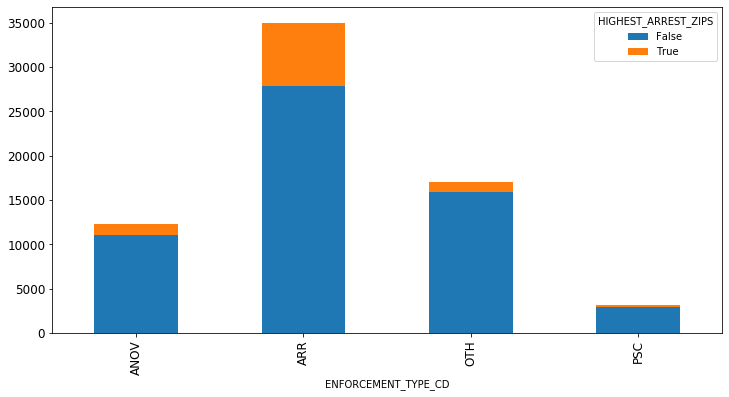

In [70]:
# let's see if we can visualize the impact of these two zip codes

df_clean.groupby(["ENFORCEMENT_TYPE_CD", "HIGHEST_ARREST_ZIPS"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

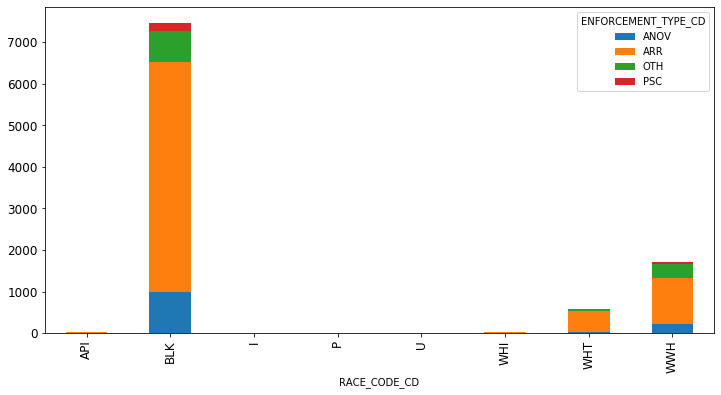

In [83]:
df_highest.groupby(["RACE_CODE_CD", "ENFORCEMENT_TYPE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

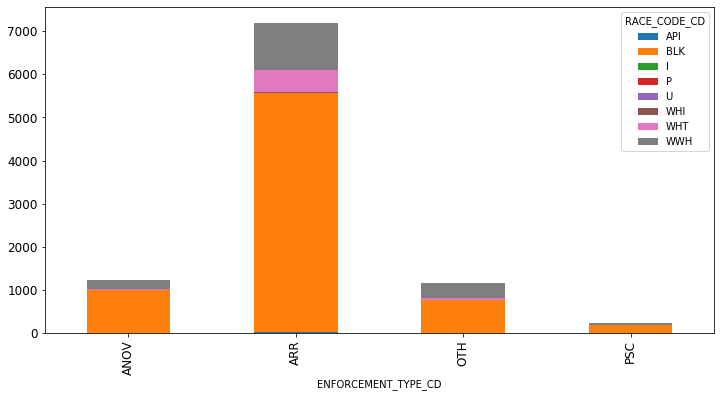

In [85]:
df_highest.groupby(["ENFORCEMENT_TYPE_CD", "RACE_CODE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

In [ ]:
# These charts are quite telling - of the four possible outcomes, the majority of stops overwhelmingly result in arrest
# Of stops that result in arrest, the race of the person is overwhelmingly Black, followed by Hispanic

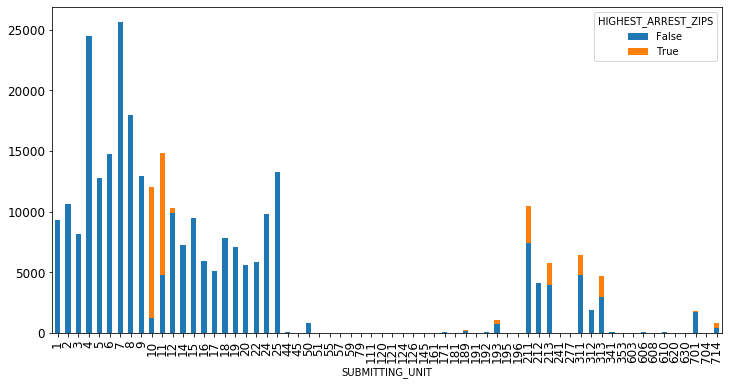

In [71]:
df_clean.groupby(["SUBMITTING_UNIT", "HIGHEST_ARREST_ZIPS"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)

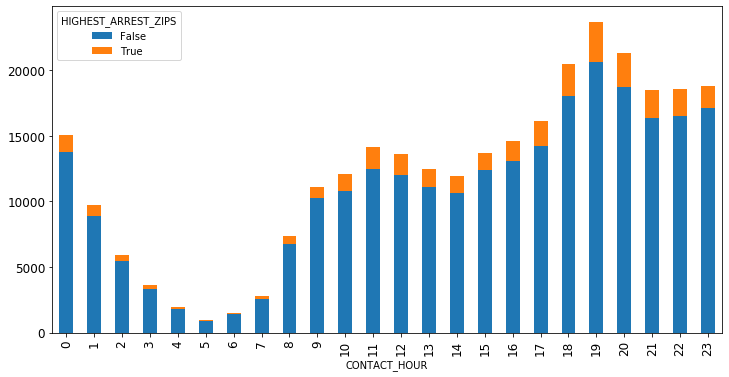

In [72]:
df_clean.groupby(["CONTACT_HOUR","HIGHEST_ARREST_ZIPS"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)


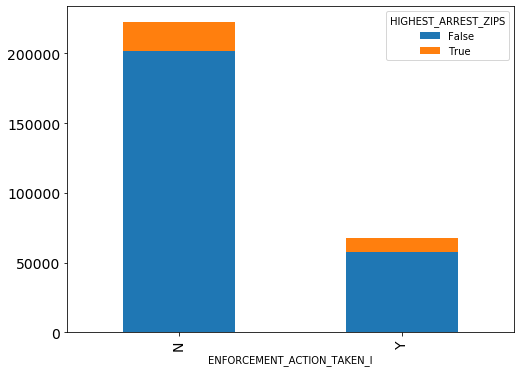

In [73]:
df_clean.groupby(["ENFORCEMENT_ACTION_TAKEN_I", "HIGHEST_ARREST_ZIPS"]).size().unstack().plot(kind='bar', stacked=True, figsize=(8,6),fontsize=14) 


In [ ]:
# While arrests are high in those two zip codes, there are even more interactions that don't result in an arrest!


In [ ]:
# We've established that zip code plays a large role in predicting whether an individual will be arrested or not.
# Next, let's examine if this relationship is statsitically significant.

In [74]:
from scipy import stats # testing
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison) #tukey

In [75]:
df_clean.dropna(subset=['ZIP_CD'], inplace=True)
df_clean.ZIP_CD.isna().sum()

0

In [76]:
df_clean = df_clean[df_clean.ZIP_CD != '``']


In [77]:
# change zip from object to int

df_clean['ZIP_CD'] = df_clean['ZIP_CD'].astype(int)


In [78]:
from statsmodels.formula.api import ols


formula = 'ARREST_BINARY ~ C(ZIP_CD)'
lm = ols(formula, df_clean).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(ZIP_CD),96.0,818.304377,8.524004,82.572915,0.0
Residual,289635.0,29899.027889,0.103230,NaN,NaN


In [79]:

mc = MultiComparison(df_clean['ARREST_BINARY'],df_clean['ZIP_CD'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
    113       6007      1.0    0.9  -0.688   2.688  False
    113      46320      0.0    0.9  -1.688   1.688  False
    113      60068      0.0    0.9 -1.3783  1.3783  False
    113      60076      0.0    0.9 -1.3783  1.3783  False
    113      60077      0.0    0.9  -1.688   1.688  False
    113      60085      1.0    0.9  -0.688   2.688  False
    113      60102      0.0    0.9  -1.688   1.688  False
    113      60126      0.0    0.9  -1.688   1.688  False
    113      60139      0.0    0.9 -1.3783  1.3783  False
    113      60160      0.0    0.9  -1.688   1.688  False
    113      60171      0.0    0.9  -1.688   1.688  False
    113      60202      0.0    0.9 -1.0375  1.0375  False
    113      60302      0.4    0.9 -0.7532  1.5532  False
    113      60304   0.1667    0.9 -0.9587   1.292  False
    113      6

In [80]:
formula = 'ARREST_BINARY ~ C(RACE_CODE_CD)'
lm = ols(formula, df_clean).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(RACE_CODE_CD),8.0,200.749892,25.093736,238.238756,0.0
Residual,289723.0,30516.582374,0.105330,NaN,NaN


In [81]:
mc = MultiComparison(df_clean['ARREST_BINARY'],df_clean['RACE_CODE_CD'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   API    BLK   0.0596  0.001  0.0397  0.0795   True
   API      I  -0.0288 0.7647 -0.0837  0.0262  False
   API      P   0.0147    0.9 -0.0359  0.0654  False
   API      U   0.9246  0.001  0.4209  1.4283   True
   API    WBH   0.9246  0.001  0.5885  1.2607   True
   API    WHI   0.8856  0.001  0.7692   1.002   True
   API    WHT   0.0173 0.1956 -0.0035  0.0381  False
   API    WWH   0.0124 0.5911 -0.0078  0.0326  False
   BLK      I  -0.0884  0.001 -0.1396 -0.0371   True
   BLK      P  -0.0449 0.0714 -0.0915  0.0018  False
   BLK      U    0.865  0.001  0.3617  1.3683   True
   BLK    WBH    0.865  0.001  0.5294  1.2006   True
   BLK    WHI   0.8261  0.001  0.7113  0.9408   True
   BLK    WHT  -0.0423  0.001 -0.0491 -0.0355   True
   BLK    WWH  -0.0471  0.001 -0.0517 -0.0425   True
     I      P   0.0435  0.569 -0.0258  0.1128 

In [ ]:
# Using Ordinary Least Squares, we've determined that there is a statistically significant different in arrest rates
# by zip code, as well as by race. 

# Using tukey, we're able to iterate through a list of each and return a true or false value for each pairing.